In [7]:
import pandas as pd
import numpy as np
import import_ipynb
import utils_cdt as cdt
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import date

In [8]:
infoDataBases = {"ip":"AZ2D-MASKDB-220.DEVCDT.COM.BR",
                 "base":"Fortbrasil"}

In [40]:
consulta = cdt.resultQuery("mdl_parcelamento_fatura.sql")
df = cdt.extrairDados(infoDataBases,consulta,path='../data/',arquivo="mdl_parcelamento_faturas.csv",spark=False,objSpark=None)

In [41]:
df['dtvencimento'] = pd.to_datetime(df.DtFormat, format="%Y-%m-%d")

#Somente os vencimentos de dia 20
#df = df.loc[df.dtvencimento.dt.day == 20]

In [42]:
SQL_Query_2 = df
# Definindo as classes
servicostipo = {"Parcelamento" : 1, "Parcelamento Rotativo" : 0, "Semoferta": 2}

# Aplicando o mapeamento ao dataset
SQL_Query_2['tiposervico'] = SQL_Query_2['tiposervico'].map(servicostipo)

In [43]:
def preProcessamento(dataframe):
    
    preditorasruins = ['NumeroDocumento','CotacaoDolarCorte', 'PontosConcedidos', 'PontosRemanescentes',
       'CETAnual', 'LimiteSaqueNacGlobal', 'NaoFinanciavelExtrato',
       'StatusEnvioFaturaPorEmail', 'LimiteMaximo', 'LimiteGlobalCredito',
       'NaoFinanciavelAnteriorFinal', 'PontuacaoUsadaCiclo',
       'PrincipalParcelado', 'PontuacaoTotalCiclo', 'JurosMora',
       'FlagPagamento', 'QuantidadePortadores', 'Vencimento3', 'Vencimento2',
       'BaseMultaCobrada', 'AniversarioAnuidade2', 'AniversarioAnuidade1',
       'FlagEmiteExtrato', 'FlagAnuidade', 'FlagRefinanciamento', 'FlagMulta',
       'NaoFinanciavelAtualFinal', 'QtdeVencimento','CETMensal', 'FlagSMSExtratoIncondicional',
       'SaldoExtratoAnteriorAjustado', 'InternacionaisDolarExtrato',
       'InternacionaisReaisExtrato', 'DebitosInternacionais',
       'DebitosDiversosNacionais', 'ComprasInternacionaisDolar',
       'SaquesInternacionaisDolar', 'DiversosInternacionaisDolar',
       'CorrecaoCreditoMinimo', 'CreditoPagamentoMinimo',
       'DespesasInternacionaisDolar', 'DespesasInternacionaisReais',
       'SaquesNacionais', 'EncargosAtraso', 'TerminoPeriodoFaturado','FlagOverLimit']
                              
    # Removendo colunas não utilizadas
    dataframe = dataframe.drop(columns=preditorasruins)


    # Remove colunas que contem ID
    cols_id = [c for c in dataframe.columns if c.lower()[:2] == 'id']

    dataframe = dataframe.drop(columns=cols_id)

    # Removendo colunas do time data
    dataframe = dataframe.drop(columns=dataframe.select_dtypes(include=['datetime64','O']).columns.to_list())

    # Criando algumas features
    dataframe['md_sl_enc'] = dataframe['SaldoAnteriorFinal'] / dataframe['EncargosFinanciamento']
    dataframe['md_tn_cn'] = dataframe['TarifasNacionais'] / dataframe['CreditosNacionais']

    # Ajutando valores para arrendodamente de 2 casas decimais e reitrada de valores Nan
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan)
    dataframe = dataframe.fillna(0)
    dataframe = dataframe.round(2)
    dataframe = dataframe.abs()
    
    from category_encoders.ordinal import OrdinalEncoder
    encoder = OrdinalEncoder(cols=['NumeroCiclo','Status'])
    dataframe = encoder.fit_transform(dataframe)
    
    return dataframe

In [44]:
SQL_Query_2 = preProcessamento(SQL_Query_2)

In [ ]:
#SQL_Query_2[SQL_Query_2.columns[1:]].corr()['tiposervico'][:]

In [45]:
# Verificando como os dados estão distribuídos
parcelamentos = len(SQL_Query_2.loc[SQL_Query_2['tiposervico'] == 1])
rotativos = len(SQL_Query_2.loc[SQL_Query_2['tiposervico'] == 0])
semoferta = len(SQL_Query_2.loc[SQL_Query_2['tiposervico'] == 2])
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parcelamentos, (parcelamentos/ (parcelamentos + rotativos + semoferta)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotativos, (rotativos/ (parcelamentos + rotativos + semoferta)) * 100))
print("Número de Casos de Sem Oferta     : {0} ({1:2.2f}%)".format(semoferta, (semoferta/ (parcelamentos + rotativos + semoferta)) * 100))

Número de Casos de Parcelamentos: 10000 (68.67%)
Número de Casos de Rotativos     : 2120 (14.56%)
Número de Casos de Sem Oferta     : 2443 (16.78%)


In [46]:
from sklearn.model_selection import train_test_split

In [47]:
# Seleção de variáveis preditoras (Feature Selection)
atributos = SQL_Query_2.columns.to_list()
atributos.remove('tiposervico')

In [48]:
# Variável a ser prevista
atrib_prev = ['tiposervico']

In [49]:
# Criando objetos
X = SQL_Query_2[atributos].values
Y = SQL_Query_2[atrib_prev].values

In [50]:
print(f"Y unicos: {np.unique(Y)} ")

Y unicos: [0. 1. 2.] 


In [51]:
# Definindo a taxa de split
split_test_size = 0.30

In [52]:
# Criando dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = split_test_size, random_state = 42)

In [53]:
print(f"X_treino shape: {X_treino.shape} \nX_teste shape: {X_teste.shape} ")

X_treino shape: (10194, 31) 
X_teste shape: (4369, 31) 


In [54]:
# Imprimindo os resultados
print("{0:0.2f}% nos dados de treino".format((len(X_treino)/len(SQL_Query_2.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X_teste)/len(SQL_Query_2.index)) * 100))

70.00% nos dados de treino
30.00% nos dados de teste


In [55]:
print(f"Y_treino unicos: {np.unique(Y_treino)} ")
print(f"Y_teste unicos: {np.unique(Y_teste)} ")

Y_treino unicos: [0. 1. 2.] 
Y_teste unicos: [0. 1. 2.] 


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [582]:
"""
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_treino, Y_treino.ravel())
"""

'\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestClassifier()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n# Fit the random search model\nrf_random.fit(X_treino, Y_treino.ravel())\n'

In [583]:
#rf_random.best_params_ 

In [58]:
#modelo_v2 = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=600,min_samples_leaf=4,min_samples_split=10,max_depth=90,bootstrap=False, max_features='sqrt')
#modelo_v2.fit(X_treino, Y_treino.ravel())

modelo_v2 = RandomForestClassifier(random_state = 42, n_jobs = -1,n_estimators=200, min_samples_split=10,min_samples_leaf=2, max_depth=50, bootstrap = True)
modelo_v2.fit(X_treino, Y_treino.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'Importância de cada feature')

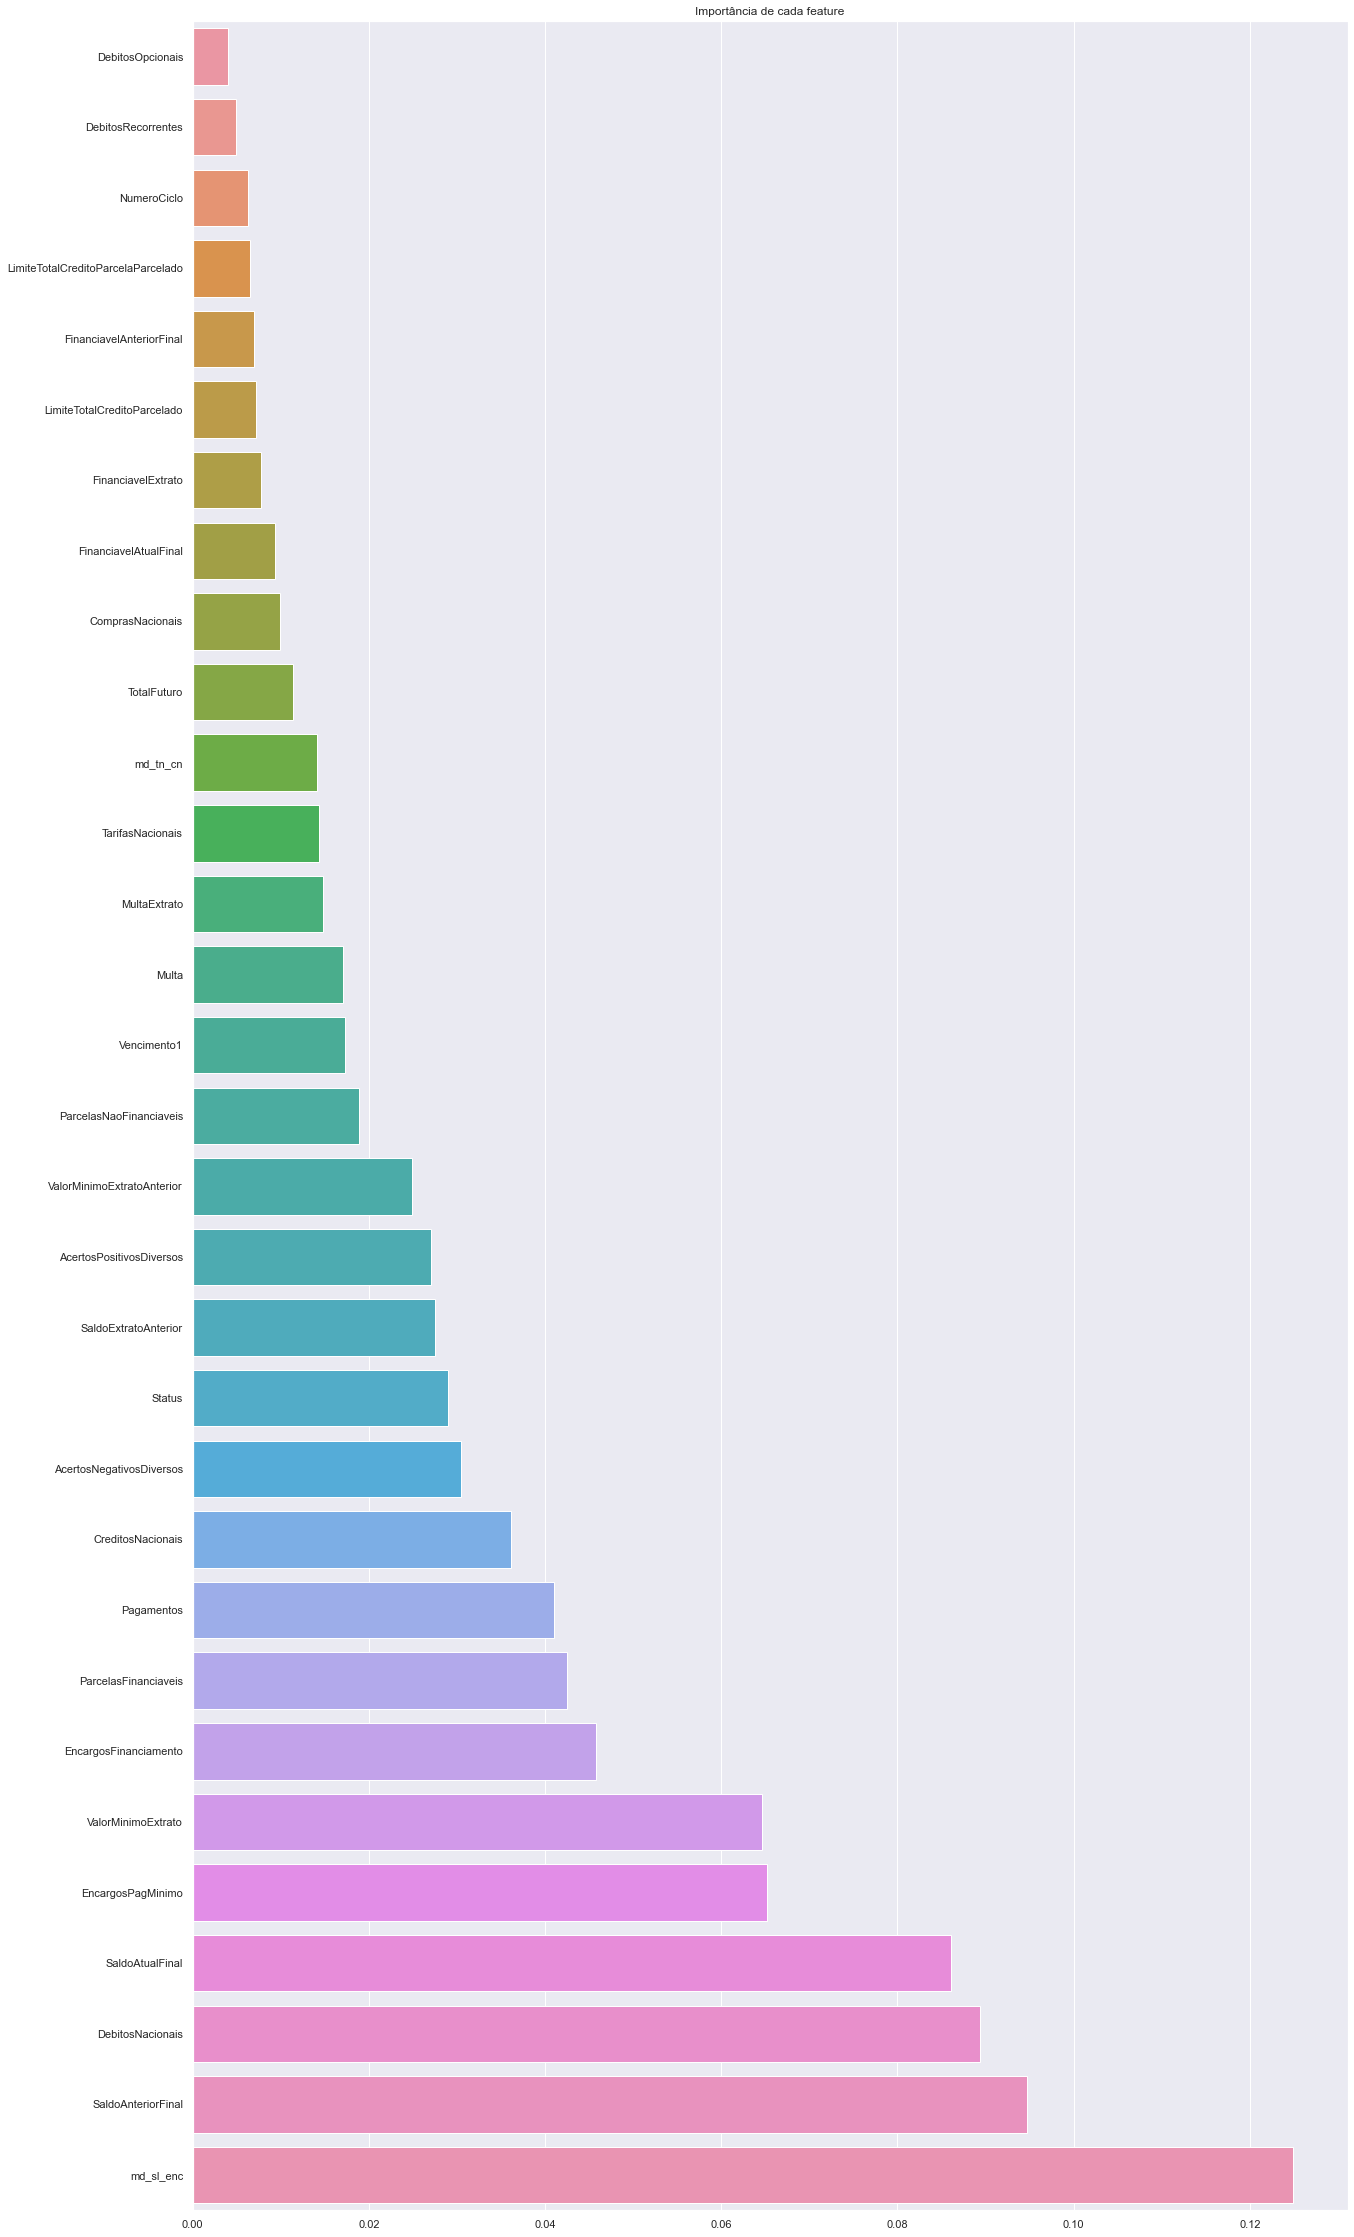

In [59]:
#Plota gráfico com as features mais importantes em ordem crescente

import seaborn as sns
importances = pd.Series(data=modelo_v2.feature_importances_, index=atributos)
importances = importances.sort_values()
sns.set(rc={'figure.figsize':(20.7,40.27)})
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [60]:
importances = pd.DataFrame({'feature':atributos,'importance':np.round(modelo_v2.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.loc[importances.importance <= 0].index

Index([], dtype='object', name='feature')

In [61]:
# Verificando os dados de treino
rf_predict_train = modelo_v2.predict(X_treino)
print("RandomForestClassifer:")
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_treino, rf_predict_train)))

RandomForestClassifer:
Exatidão (Accuracy): 0.9676


In [62]:
# Verificando nos dados de teste
rf_predict_test = modelo_v2.predict(X_teste)
print("RandomForestClassifer - Teste:")
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_teste, rf_predict_test)))
print()

RandomForestClassifer - Teste:
Exatidão (Accuracy): 0.9332



In [63]:
parce_sistema = len([x for x in Y_teste if x == 1])
rotat_sistema = len([x for x in Y_teste if x == 0])
semoferta_sistema = len([x for x in Y_teste if x == 2])

parce_previs = len([x for x in rf_predict_test if x == 1])
rotat_previs = len([x for x in rf_predict_test if x == 0])
semoferta_previs = len([x for x in rf_predict_test if x == 2])

In [64]:
print("Total de parcelamentos previsto pelo modelo:")
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parce_previs, (parce_previs/ (parce_previs + rotat_previs + semoferta_previs)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotat_previs, (rotat_previs/ (parce_previs + rotat_previs + semoferta_previs)) * 100))
print("Número de Casos sem Oferta     : {0} ({1:2.2f}%)".format(semoferta_previs, (semoferta_previs/ (parce_previs + rotat_previs + semoferta_previs)) * 100))
print("Total geral :  {0}".format(parce_previs + rotat_previs + semoferta_previs))

print("")

print("Total de parcelamentos ofertados pelo sistema do ultimo corte:")
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parce_sistema, (parce_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotat_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de sem oferta     : {0} ({1:2.2f}%)".format(semoferta_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Total geral : {0} ".format(parce_sistema + rotat_sistema + semoferta_sistema))


print("")

print("Diferença entre ofertado pelo sistema x previsto pelo modelo:")
print("Diferença em Parcelamentos: ({0:2.2f}%)".format((parce_previs/parce_sistema)*100-100))
print("Diferença em Rotativos     : ({0:2.2f}%)".format((rotat_previs/rotat_sistema)*100-100))
print("Diferença em Sem ofertas     : ({0:2.2f}%)".format((semoferta_previs/semoferta_sistema)*100-100))

print("")


print("Total de ofertas: {0}".format(parce_sistema + rotat_sistema + semoferta_sistema))

Total de parcelamentos previsto pelo modelo:
Número de Casos de Parcelamentos: 3111 (71.21%)
Número de Casos de Rotativos     : 684 (15.66%)
Número de Casos sem Oferta     : 574 (13.14%)
Total geral :  4369

Total de parcelamentos ofertados pelo sistema do ultimo corte:
Número de Casos de Parcelamentos: 3031 (69.38%)
Número de Casos de Rotativos     : 646 (14.79%)
Número de Casos de sem oferta     : 692 (14.79%)
Total geral : 4369 

Diferença entre ofertado pelo sistema x previsto pelo modelo:
Diferença em Parcelamentos: (2.64%)
Diferença em Rotativos     : (5.88%)
Diferença em Sem ofertas     : (-17.05%)

Total de ofertas: 4369


In [65]:
from sklearn.metrics import classification_report
print(classification_report(Y_teste, rf_predict_test, target_names=['Parcelamento','Parcelamento Rotativo','Semoferta']))

                       precision    recall  f1-score   support

         Parcelamento       0.91      0.96      0.93       646
Parcelamento Rotativo       0.94      0.97      0.95      3031
            Semoferta       0.92      0.76      0.84       692

             accuracy                           0.93      4369
            macro avg       0.92      0.90      0.91      4369
         weighted avg       0.93      0.93      0.93      4369



In [68]:
import pickle
filename = 'models/mdl_parcelamento_'+infoDataBases["base"]+'.sav'
pickle.dump(modelo_v2, open(filename, 'wb'))
pickle.

## Aplicando a validação do ultimo corte para o modelo e comparando quantidade de ofertas lançadas pelo sistema x Ofertas prevista pelo modelo

In [592]:
consulta = cdt.resultQuery("parcelamento_fatura.sql")

In [593]:
dfanalise = cdt.extrairDados(infoDataBases,consulta,arquivo="parcelamento_fatura.csv",spark=False,objSpark=None)

In [594]:
SQL_Query = dfanalise
# Definindo as classes
servicostipo = {"Parcelamento" : 1, "Parcelamento Rotativo" : 0, "Semoferta": 2}

# Aplicando o mapeamento ao dataset
SQL_Query['tiposervico'] = SQL_Query['tiposervico'].map(servicostipo)

In [595]:
SQL_Query = preProcessamento(SQL_Query)

In [596]:
# Criando objetos
# Seleção de variáveis preditoras (Feature Selection)
valores = SQL_Query[atributos].values

In [597]:
# Verificando como os dados estão distribuídos
parce_sistema = len(SQL_Query.loc[SQL_Query['tiposervico'] == 1])
rotat_sistema = len(SQL_Query.loc[SQL_Query['tiposervico'] == 0])
semoferta_sistema = len(SQL_Query.loc[SQL_Query['tiposervico'] == 2])
print("Total de parcelamentos ofertados pelo sistema do ultimo corte:")
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parce_sistema, (parce_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotat_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de sem oferta     : {0} ({1:2.2f}%)".format(semoferta_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Total de casos de ofertas: {0}".format(parce_sistema+rotat_sistema+semoferta_sistema))

Total de parcelamentos ofertados pelo sistema do ultimo corte:
Número de Casos de Parcelamentos: 19968 (81.44%)
Número de Casos de Rotativos     : 1975 (8.05%)
Número de Casos de sem oferta     : 2577 (8.05%)
Total de casos de ofertas: 24520


In [598]:
#Realizando previsão das ofertas com base nos dados do utimo corte.
result_model = modelo_v2.predict(valores)

In [599]:
# Criando objetos
X = SQL_Query[atributos].values
Y = SQL_Query[atrib_prev].values


# Verificando os dados
rf_predict_test = modelo_v2.predict(X)
print("RandomForestClassifer - Teste:")
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y, rf_predict_test)))
print()

RandomForestClassifer - Teste:
Exatidão (Accuracy): 0.9244



In [600]:
# Verificando como os dados estão distribuídos
parcelamentos = len([x for x in result_model if x == 1])
rotativos = len([x for x in result_model if x == 0])
noofertas = len([x for x in result_model if x == 2])
print("Total de parcelamentos previsto pelo modelo com base nos dados do ultimo corte:")
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parcelamentos, (parcelamentos/ (parcelamentos + rotativos + noofertas)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotativos, (rotativos/ (parcelamentos + rotativos + noofertas)) * 100))
print("Número de Casos sem Oferta     : {0} ({1:2.2f}%)".format(noofertas, (rotativos/ (parcelamentos + rotativos + noofertas)) * 100))
print("Total geral :  {0}".format(parcelamentos + rotativos + noofertas))

print("")

print("Total de parcelamentos ofertados pelo sistema do ultimo corte:")
print("Número de Casos de Parcelamentos: {0} ({1:2.2f}%)".format(parce_sistema, (parce_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de Rotativos     : {0} ({1:2.2f}%)".format(rotat_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Número de Casos de sem oferta     : {0} ({1:2.2f}%)".format(semoferta_sistema, (rotat_sistema/ (parce_sistema + rotat_sistema + semoferta_sistema)) * 100))
print("Total geral : {0} ".format(parce_sistema + rotat_sistema + semoferta_sistema))


print("")

print("Diferença entre ofertado pelo sistema x previsto pelo modelo:")
print("Diferença em Parcelamentos: ({0:2.2f}%)".format((parcelamentos/parce_sistema)*100-100))
print("Diferença em Rotativos     : ({0:2.2f}%)".format((rotativos/rotat_sistema)*100-100))
print("Diferença em Sem ofertas     : ({0:2.2f}%)".format((noofertas/semoferta_sistema)*100-100))

print("")


print("Total de ofertas: {0}".format(parce_sistema + rotat_sistema + semoferta_sistema))

Total de parcelamentos previsto pelo modelo com base nos dados do ultimo corte:
Número de Casos de Parcelamentos: 20649 (84.21%)
Número de Casos de Rotativos     : 1712 (6.98%)
Número de Casos sem Oferta     : 2159 (6.98%)
Total geral :  24520

Total de parcelamentos ofertados pelo sistema do ultimo corte:
Número de Casos de Parcelamentos: 19968 (81.44%)
Número de Casos de Rotativos     : 1975 (8.05%)
Número de Casos de sem oferta     : 2577 (8.05%)
Total geral : 24520 

Diferença entre ofertado pelo sistema x previsto pelo modelo:
Diferença em Parcelamentos: (3.41%)
Diferença em Rotativos     : (-13.32%)
Diferença em Sem ofertas     : (-16.22%)

Total de ofertas: 24520
